Frieburg dataset-googlenet

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset=td.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=td.DataLoader(train_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test=td.DataLoader(test_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_val=td.DataLoader(val_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_loader,test_loader,val_loader=load_data(path=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset', 
                                          test_split=0.2,val_split= 0.2,batch_size=32, input_size=[256,256])

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

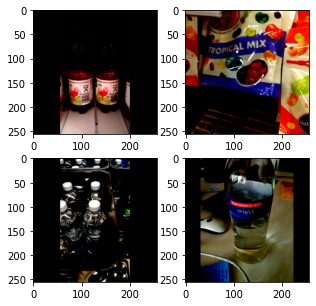

In [ ]:
plot_data_loader(train_loader,(2,2))

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet',pretrained=True)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      model.aux_logits=False
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model1,accuracy1,loss1,val_acc1,val_loss1=train( model, train_loader,val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 1.9024, Accuracy: 50.75%, Validation Loss : 1.3377, Validation Accuracy : 61.02%,
Epoch [2/50], Loss: 3.0843, Accuracy: 9.14%, Validation Loss : 3.0011, Validation Accuracy : 11.11%,
Epoch [3/50], Loss: 2.9152, Accuracy: 11.15%, Validation Loss : 2.8314, Validation Accuracy : 14.37%,
Epoch [4/50], Loss: 2.8722, Accuracy: 10.49%, Validation Loss : 2.8667, Validation Accuracy : 14.80%,
Epoch [5/50], Loss: 2.8546, Accuracy: 11.61%, Validation Loss : 2.8247, Validation Accuracy : 14.65%,
Epoch [6/50], Loss: 2.8296, Accuracy: 13.06%, Validation Loss : 2.8182, Validation Accuracy : 14.65%,
Epoch [7/50], Loss: 2.8568, Accuracy: 11.71%, Validation Loss : 3.0692, Validation Accuracy : 6.54%,
Epoch [8/50], Loss: 2.9314, Accuracy: 8.12%, Validation Loss : 3.0923, Validation Accuracy : 10.23%,
Epoch [9/50], Loss: 2.8809, Accuracy: 11.05%, Validation Loss : 2.8921, Validation Accuracy : 9.81%,
Epoch [10/50], Loss: 2.8088, Accuracy: 12.64%, Validation Loss : 2.8895

In [ ]:
model1.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = model1.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

In [ ]:
torch.save(model1, 'model_googlenet1.pt')
#model = torch.load('/content/drive/MyDrive/Colab Notebooks')
#model.eval()

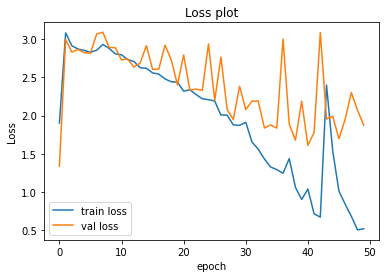

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()


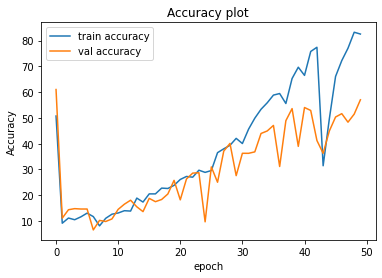

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()

Grocery dataset-Googlenet

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data_grocery_store(path, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.CenterCrop(224), transforms.RandomRotation(5), transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    data_loader=td.DataLoader(data1,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader

train_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train', batch_size=32, input_size=[64,64])
test_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Test', batch_size=32, input_size=[64,64])
val_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Val', batch_size=32, input_size=[64,64])

In [ ]:
plot_data_loader(train_loader2,(2,2))

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet',pretrained=True)
optimizer2 = torch.optim.Adam(model2.parameters(),lr=0.001)
criterion2 = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      model.aux_logits=False
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model2,accuracy2,loss2,val_acc2,val_loss2=train(model2, train_loader2,val_loader2, criterion2, optimizer2,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 1.4030, Accuracy: 66.88%, Validation Loss : 1.0724, Validation Accuracy : 70.01%,
Epoch [2/50], Loss: 3.2282, Accuracy: 14.90%, Validation Loss : 2.8072, Validation Accuracy : 16.49%,
Epoch [3/50], Loss: 2.1795, Accuracy: 29.82%, Validation Loss : 2.5150, Validation Accuracy : 25.87%,
Epoch [4/50], Loss: 1.6563, Accuracy: 43.99%, Validation Loss : 1.5540, Validation Accuracy : 47.84%,
Epoch [5/50], Loss: 1.1125, Accuracy: 61.81%, Validation Loss : 1.4255, Validation Accuracy : 56.17%,
Epoch [6/50], Loss: 0.9088, Accuracy: 69.45%, Validation Loss : 1.4664, Validation Accuracy : 55.72%,
Epoch [7/50], Loss: 0.5961, Accuracy: 80.31%, Validation Loss : 1.1675, Validation Accuracy : 62.97%,
Epoch [8/50], Loss: 0.6029, Accuracy: 80.15%, Validation Loss : 0.8859, Validation Accuracy : 71.31%,
Epoch [9/50], Loss: 0.4833, Accuracy: 84.33%, Validation Loss : 1.2554, Validation Accuracy : 66.57%,
Epoch [10/50], Loss: 0.5147, Accuracy: 83.49%, Validation Loss : 0.

In [ ]:
model2.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 2497 test images: 53.42410893071686 %


[1.4030278427036185, 3.228152135485097, 2.179536422616557, 1.6562528014183044, 1.1124927589767857, 0.9087635498297842, 0.5961370199526611, 0.6028931936935374, 0.4833240780587259, 0.5147232030959505, 0.3311333125947337, 0.37348188626530926, 0.2646281807438323, 0.2696243628467384, 0.28678885957618294, 0.14372990547532313, 0.2585854678365745, 0.12131534556024953, 0.21002292696778713, 0.20610764995217323, 0.2189514295835244, 0.17720600167338393, 0.23995535728203035, 0.19406641152148185, 0.15248837643057891, 0.14003729183030755, 0.08968408343284145, 0.17968951324368582, 0.031304099481770355, 0.1671643849641489, 0.14611316610764907, 0.23973283759857478, 0.19418481727571865, 0.09692428303012428, 0.11678615171235594, 0.01807564173903206, 0.012790569021538096, 0.013425467575488207, 0.15574193106716083, 0.1526101771068122, 0.18599683304905498, 0.14461679498689542, 0.13005956990558556, 0.11335960872728672, 0.01409572316295357, 0.001262606242993283, 0.0005271185509388344, 0.00032017699446011027, 0

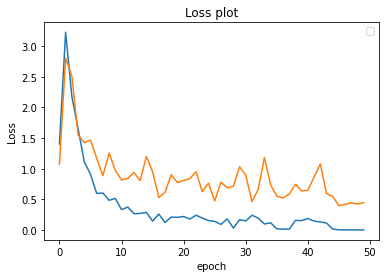

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(loss2)
plt.plot(val_loss2)
plt.legend()

print(loss2)

[66.87987329434698, 14.897051656920077, 29.819992690058477, 43.99061890838207, 61.81164717348928, 69.4474902534113, 80.3149366471735, 80.15046296296296, 84.32931286549707, 83.48866959064327, 88.47161306042885, 88.3406432748538, 91.49153265107213, 91.5402655945419, 91.67884990253411, 95.05056042884989, 91.73824317738791, 96.44858674463937, 93.55506822612085, 93.11038011695906, 93.20784600389864, 94.9759381091618, 93.33120126705653, 93.90685916179338, 95.33838937621832, 95.64144736842105, 96.86738547758284, 94.31042884990252, 99.09539473684211, 95.47240497076022, 95.8470394736842, 93.54440789473684, 93.82462231968812, 97.16282894736842, 96.95723684210526, 99.50657894736842, 99.62231968810916, 99.62993421052632, 95.77546296296296, 95.01705653021443, 94.03021442495127, 95.30488547758284, 96.33284600389864, 96.4150828460039, 99.71217105263158, 100.0, 100.0, 100.0, 100.0, 100.0]


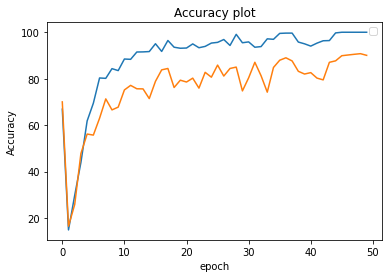

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy2)
plt.plot(val_acc2)  
plt.legend()

print(accuracy2)

In [ ]:
X=train_loader2.imgs[:500]
Y=train_loader2.labels[:500,0]
X=X.reshape(X.shape[0],X.shape[1]*X.shape[2])


print(X.shape)
print(Y.shape)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_embedded = tsne.fit_transform(X)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
plt_scatter_plot=plt.scatter(X_embedded[:,0],X_embedded[:,1],c=Y)
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('DIm_2')
plt.show()
plt.close()